---
highlight-style:
  light: arrow.theme
  dark: arrow-dark.theme
format:
  html:
    code-line-numbers: false
    code-overflow: wrap
---

# Integer Programming {#sec-integer}

Integer programming has a wide range of applications across various industries and domains. Some of the classical applications of integer programming include:

- Production Planning and Scheduling: Integer programming is widely used in production planning and scheduling to optimize the allocation of resources, such as machines, workers, and raw materials. It helps to minimize costs and maximize efficiency by determining the optimal production schedule.

- Network Optimization: Integer programming is used in network optimization problems such as routing, scheduling, and allocation of resources in transportation networks, telecommunication networks, and supply chain management.

- Facility Location: Integer programming is used in facility location problems, which involve determining the optimal location for a facility based on various factors such as demand, supply, and transportation costs. It is commonly used in logistics, transportation, and distribution industries.

- Portfolio Optimization: Integer programming is used in finance to optimize investment portfolios, where the goal is to maximize the returns on the investment while minimizing risk.

- Cutting Stock and Bin Packing: Integer programming is used in cutting stock and bin packing problems where items of varying sizes must be packed into containers or cut from a stock. This is commonly used in the packaging and manufacturing industries.

- Crew Scheduling: Integer programming is used in crew scheduling problems, where the goal is to optimize the allocation of crew members to different shifts, duties, or activities. It is commonly used in industries such as airlines, railways, and public transportation.

- Timetabling: Integer programming is used in timetabling problems such as scheduling classes, exams, and events in academic institutions. It helps to minimize scheduling conflicts and maximize resource utilization.

This chapter explores the various methods that Google OR-Tools provides for modeling and solving (mixed) integer linear programming problems. The first step is to review the additional conditions that arise when modeling integer variables and solving integer programs. Following that, we use specific instances to demonstrate how these techniques are applied.

## Modeling Capabilities



When modeling integer programs, there are two main tasks that require attention. The first is declaring integer variables, and the second is selecting a solver that is capable of solving integer programs.

### Declaring Integer Variables

As reviewed in @sec-linear, Google OR-Tools provides two options to create integer variables:

+ The `Var(lb, ub, integer: bool, name)` function
+ The `IntVar(lb, ub, name)` function
+ The `Variable.SetInteger(integer: bool)` function

In the code snippet below, we create three integer variables using all the aforementioned approaches:

In [13]:
from ortools.linear_solver import pywraplp

solver = pywraplp.Solver.CreateSolver('SCIP')

# option 1
x = solver.Var(lb=0, ub=10, integer=True, name='x')

# option 2
y = solver.IntVar(lb=10, ub=20, name='y')

# option 3
z = solver.NumVar(lb=0, ub=5.5, name='z')
z.SetInteger(integer=True)

We can verify the types of variables $x, y, z$:

In [14]:
print(f"x is integer? {x.integer()}")
print(f"y is integer? {y.integer()}")
print(f"z is integer? {z.integer()}")

x is integer? True
y is integer? True
z is integer? True


### Selecting an Integer Solver

There are several solvers available for solving integer programs, and some options include:

- CBC_MIXED_INTEGER_PROGRAMMING or CBC
- BOP_INTEGER_PROGRAMMING or BOP
- SAT_INTEGER_PROGRAMMING or SAT or CP_SAT
- SCIP_MIXED_INTEGER_PROGRAMMING or SCIP
- GUROBI_MIXED_INTEGER_PROGRAMMING or GUROBI or GUROBI_MIP
- CPLEX_MIXED_INTEGER_PROGRAMMING or CPLEX or CPLEX_MIP
- XPRESS_MIXED_INTEGER_PROGRAMMING or XPRESS or XPRESS_MIP
- GLPK_MIXED_INTEGER_PROGRAMMING or GLPK or GLPK_MIP

It's important to note that some of these solvers are open-source, while others require a commercial license.
The code block above demonstrates how to create an instance of an integer solver. To do so, we simply need to specify the name of the solver in the Solver.CreateSolver() function.

In [15]:
solver = pywraplp.Solver.CreateSolver('CBC')

## Applications

In this section, we use Google OR-Tools to solve some of the classical integer programming problems.

### Job Shop Scheduling Problem

In the job shop scheduling problem (JSSP), there are a set of $n$ jobs $\mathcal{J}$ and a set of $m$ machines $\mathcal{M}$, and each job $j \in \mathcal{J}$ has a list of operations, given by $(o_1^j, \cdots, o_h^j, \cdots, o_m^j)$, that must be carried on the machines.
The order of operations in the list also indicates the processing order of the job, and $o_h^j$ represents the $h$-th operation of the job $j$.
In addition, the processing time of job $j$ on machine $i$, denoted by $p_{ij}$, is known in advance and is a non-negative integer.
At any moment of time, each machine can only process at most one job and no preemption is allowed which means that a job must completes its processing on a machine once it starts on that machine.
The objective is to find a processing schedule of the jobs on the machines such that the makespan, the completion time of the last operation of any job, is minimized.


To test the modeling of JSSP, we use a benchmarking instance from the OR-Library (@or-library), shown in the box below.
The two numbers in the first line represent the number of jobs and the number of machines, respectively.
Each remaining line contains the operations, processing machine and processing time, for each job.
Note that the machines are numbered starting from 0.

::: {.callout-note icon=false appearance="default}

## Instance abz5 (@or-library)

10	10	<br />
4	88	8	68	6	94	5	99	1	67	2	89	9	77	7	99	0	86	3	92<br />
5	72	3	50	6	69	4	75	2	94	8	66	0	92	1	82	7	94	9	63<br />
9	83	8	61	0	83	1	65	6	64	5	85	7	78	4	85	2	55	3	77<br />
7	94	2	68	1	61	4	99	3	54	6	75	5	66	0	76	9	63	8	67<br />
3	69	4	88	9	82	8	95	0	99	2	67	6	95	5	68	7	67	1	86<br />
1	99	4	81	5	64	6	66	8	80	2	80	7	69	9	62	3	79	0	88<br />
7	50	1	86	4	97	3	96	0	95	8	97	2	66	5	99	6	52	9	71<br />
4	98	6	73	3	82	2	51	1	71	5	94	7	85	0	62	8	95	9	79<br />
0	94	6	71	3	81	7	85	1	66	2	90	4	76	5	58	8	93	9	97<br />
3	50	0	59	1	82	8	67	7	56	9	96	6	58	4	81	5	59	2	96<br />
:::

Suppose this instance data is saved in a file named *abz5.txt* and the code below defines an utility function to read and parse the instance for later use.

In [20]:
def read_jssp_instance(filename: str):
    with open(filename) as f:
        num_jobs, num_machines = [int(x) for x in next(f).split()]
        operations = []
        processing_times = {}
        job_idx = 0
        for line in f:
            info = [int(x) for x in line.split()]
            arr = [info[2 * m] for m in range(num_machines)]
            times = {info[2 * m]: info[2 * m + 1]
                    for m in range(num_machines)}
            operations.append(arr)
            processing_times[job_idx] = times
            job_idx += 1
    return num_jobs, num_machines, operations, processing_times

We present here three classical formulations of the JSSP from the literature and implement them using Google OR-Tools.

1. Disjunctive model

This model is taken from @ku_mixed_2016 and @manne_job-shop_1960. 
The decision variables are defined as follows:

- $x_{ij}$: the processing starting time of job $j$ on machine $i$
- $z_{ijk}$: a binary variable that equals 1 if job $j$ precedes job $k$ on machine $i$

The disjunctive model can then be stated as below.

\begin{align}
    \text{min.} &\quad C_{max} \label{jsp-dis-obj}\\
    \text{s.t.} &\quad x_{ij} \geq 0, \ \forall j \in \mathcal{J}, i \in \mathcal{M} \label{jsp-dis-cons1}\\
    &\quad x_{o_h^j, j} \geq x_{o_{h-1}^j, j} + p_{o_{h-1}^j, j}, \ \forall j \in \mathcal{J}, h = 2, \cdots, m \label{jsp-dis-cons2}\\
    &\quad x_{ij} \geq x_{ik} + p_{ik} - V \cdot z_{ijk}, \ \forall i \in \mathcal{M}, j, k \in \mathcal{J}, j < k  \label{jsp-dis-cons3}\\
    &\quad x_{ik} \geq x_{ij} + p_{ij} - V \cdot (1 - z_{ijk}), \ \forall i \in \mathcal{M}, j, k \in \mathcal{J}, j < k  \label{jsp-dis-cons4}\\
    &\quad C_{max} \geq x_{o_m^j, j} + p_{o_m^j, j}, \ \forall j \in \mathcal{J}  \label{jsp-dis-cons5}\\
    &\quad z_{ijk} \in \{0, 1\}, \ \forall i \in \mathcal{M}, j, k \in \mathcal{J} \label{jsp-dis-cons6}
\end{align}

The objective \eqref{jsp-dis-obj} aims to minimize the maximal completion time of any job $j \in \mathcal{J}$.
Constraints \eqref{jsp-dis-cons1} require that all the job processing starting time must not be negative values.
Constraints \eqref{jsp-dis-cons2} enforce the sequencing order among operations for every job, which state that the $h$-th operation of job $j$, $o_h^j$, cannot start unless its preceeding operation $o_{h - 1}^j$ finishes.
Constraints \eqref{jsp-dis-cons3} and \eqref{jsp-dis-cons4} together make sure that at most one job can be processed on a machine at any time.
To be specific, in case of job $j$ preceding job $k$ on machine $i$, $z_{ijk}$ takes the value of 1 and constraints \eqref{jsp-dis-cons4} ensure that job $k$ won't start processing on machine $i$ unless job $i$ completes processing; Otherwise, $z_{ijk}$ takes the value of 0 and constraints \eqref{jsp-dis-cons3} require that job $j$ starts processing after job $k$.
Note that both constraints are needed when we require $j < k$; Otherwise, only one of them is needed if we create a constraint for every pair of $j$ and $k$ on a machine.
Constraints \eqref{jsp-dis-cons5} derive $C_{max}$ across all jobs.
The last constraints \eqref{jsp-dis-cons6} state the variable type of $z_{ijk}$.

Now we are ready to solve this problem using Google OR-Tools based on the disjunctive formulation.
The code snippet below shows the complete code.

In [66]:
#| code-overflow: wrap
#| code-line-numbers: true

from typing import List, Dict
from ortools.linear_solver import pywraplp

# read and parse the data
filename = './data/jssp/ft06.txt'
num_jobs, num_machines, \
operations, processing_times = \
    read_jssp_instance(filename)

# create solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# create variables
infinity = solver.Infinity()
var_time: List[List] = []
for machine in range(num_machines):
    arr = [
        solver.NumVar(0, 
                    infinity, 
                    name=f'x_{machine, job}') 
        for job in range(num_jobs)
        ]
    var_time.append(arr)

var_prec: Dict = []
for machine in range(num_machines):
    mac_dict = {}
    for job_j in range(num_jobs - 1):
        for job_k in range(job_j + 1, num_jobs):
            mac_dict[(job_j, job_k)] = \
            solver.BoolVar(
                name=f'z_{machine, job_j, job_k}'
            )
    var_prec.append(mac_dict)

var_makespan = solver.NumVar(0, 
                            infinity, 
                            name='C_max')

# create objective
solver.Minimize(var_makespan)

# create constraints
for job, job_operations in enumerate(operations):
    for h in range(1, num_machines):
        curr_machine = job_operations[h]
        prev_machine = job_operations[h - 1]
        prev_time = processing_times[job][prev_machine]
        solver.Add(
            var_time[curr_machine][job] >= 
                   var_time[prev_machine][job] + 
                   prev_time
            )

V = 0
for job in processing_times:
    V += sum(processing_times[job].values())
for machine in range(num_machines):
    for job_j in range(num_jobs - 1):
        for job_k in range(job_j + 1, num_jobs):
            solver.Add(
                var_time[machine][job_j] >= 
                var_time[machine][job_k] +
                processing_times[job_k][machine] - 
                V * var_prec[machine][(job_j, job_k)]
            )
            solver.Add(
                var_time[machine][job_k] >= 
                var_time[machine][job_j] +
                processing_times[job_j][machine] - 
                V * (1 - var_prec[machine][(job_j, job_k)])
            )
            
for job in range(num_jobs):
    last_oper_machine = operations[job][-1]
    solver.Add(
        var_makespan >= 
        var_time[last_oper_machine][job] + 
        processing_times[job][last_oper_machine]
    )

status = solver.Solve()

if status == solver.OPTIMAL:
    print(f"min. makespan = {solver.Objective().Value()}")
    
    opt_time = []
    for machine in range(num_machines):
        arr = [int(var_time[machine][job].solution_value()) for job in range(num_jobs)]
        opt_time.append(arr)
    



min. makespan = 55.00000000000002


In [67]:
opt_time

[[6, 40, 19, 13, 51, 28],
 [16, 0, 47, 8, 22, 13],
 [5, 8, 0, 22, 13, 54],
 [32, 50, 5, 27, 54, 16],
 [42, 13, 48, 30, 25, 38],
 [39, 27, 9, 46, 42, 19]]

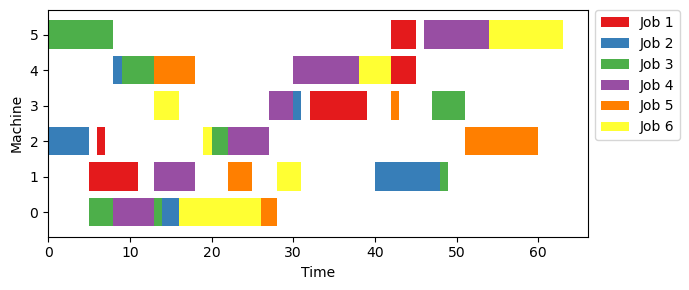

In [73]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# colors = mpl.colormaps["Dark2"].colors + mpl.colormaps["Set2"].colors
colors = mpl.colormaps["Set1"].colors

fig, ax = plt.subplots(figsize=[7, 3], dpi=100)

for idx, job in enumerate(range(num_jobs)):
    machines = operations[job]
    job_start_times = [opt_time[machine][job] for machine in range(num_machines)]
    job_processing_times = [processing_times[job][machine] for machine in operations[job]]
    
    if idx >= len(colors):
        idx = idx % len(colors)
    color = colors[idx]

    ax.barh(machines, job_processing_times, left=job_start_times, label=f'Job {job + 1}', color=color)
    
ax.set_yticks(machines)
ax.set_xlabel("Time")
ax.set_ylabel("Machine")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.03))
fig.tight_layout()
plt.show()

In [71]:
opt_time

[[6, 40, 19, 13, 51, 28],
 [16, 0, 47, 8, 22, 13],
 [5, 8, 0, 22, 13, 54],
 [32, 50, 5, 27, 54, 16],
 [42, 13, 48, 30, 25, 38],
 [39, 27, 9, 46, 42, 19]]

2. Time-indexed model

3. Rank-based model